<a href="https://colab.research.google.com/github/KCachel/FairRankTune/blob/main/examples/3_ranktune_augment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup
We need to install FairRankTune.

In [1]:
!pip install FairRankTune

We need to import FairRankTune along with some other packages.

In [2]:
import FairRankTune as frt
import numpy as np
import pandas as pd
from FairRankTune import RankTune, Metrics, Rankers
import matplotlib.pyplot as plt

# Generate partially synthetic data
RankTune can be used to stretch the usability of existing fairness datasets by generating partially synthetic data from real datasets.


Here we demonstrate the ability of RankTune to augment existing datasets by crafting rankings over that same set of items. Speciffically, we use the `Law` dataset. `Law` is commonly used in fair ranking experiments. We will first measure the fairness of the ranking produced by using the `LSAT` feature of the dataset to rank people.  Then we will use the `Law` dataset with RankTune, specifically the `GenFromItem()` function to generate rankings at different `phi` (representativeness) values. Lastly, our plots compare the rankings generated by `RankTune` and the "original LSAT ranking". For this we will use the [EXP](https://kcachel.github.io/FairRankTune/Metrics/#group-exposure-exp), [AWRF](https://kcachel.github.io/FairRankTune/Metrics/#attention-weighted-rank-fairness-awrf), and [NDKL](https://kcachel.github.io/FairRankTune/Metrics/#normalized-discounted-kl-divergence-ndkl) metrics.


In [3]:
#Construct partially synthetic data from law dataset
law_raw = pd.read_csv('https://raw.githubusercontent.com/KCachel/FairRankTune/main/examples/data/law_data.csv', sep=',')
item_ids = np.arange(0, 21791, 1, dtype=int)

#The "initial" ranking is the one produced from the LSAT score feature
sex = np.array(law_raw["sex"])
sex = sex - 1 #zero index
score = np.array(law_raw["LSAT"])
zipped = zip(score, item_ids)
sorted_zipped = sorted(zipped)
init_ranking = [element for _, element in sorted_zipped]
groups = [sex[np.argwhere(item_ids == i)[0][0]]  for i in init_ranking]
item_group_ids = dict(zip(init_ranking, groups))
init_ranking_df = pd.DataFrame(init_ranking)

#For plotting
item_counts = []
phis = []
ndkls = []
exps = []
awrfs = []

#Get fairness of the original ranking
p = 1/len(init_ranking)
exp_original, avg_exps = frt.Metrics.EXP(init_ranking_df, item_group_ids, 'MinMaxRatio')
ndkl_original = frt.Metrics.NDKL(init_ranking_df, item_group_ids)
awrf_original, avg_attns = frt.Metrics.AWRF(init_ranking_df, item_group_ids, p, 'MinMaxRatio')


#Generate data
for phi in [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]:
    print("Phi....working on...", phi)
    seed = 10
    r_cnt = 1
    ranking, item_grp_dict = frt.RankTune.GenFromItems(item_group_ids,phi, r_cnt, seed)
    exp, avg_exps = frt.Metrics.EXP(ranking, item_grp_dict, 'MinMaxRatio')
    ndkl = frt.Metrics.NDKL(ranking, item_grp_dict)
    awrf, avg_attns = frt.Metrics.AWRF(ranking, item_grp_dict, p, 'MinMaxRatio')
    phis.append(phi)
    exps.append(exp)
    ndkls.append(ndkl)
    awrfs.append(awrf)

Phi....working on... 0
Phi....working on... 0.1
Phi....working on... 0.2
Phi....working on... 0.3
Phi....working on... 0.4
Phi....working on... 0.5
Phi....working on... 0.6
Phi....working on... 0.7
Phi....working on... 0.8
Phi....working on... 0.9
Phi....working on... 1


Plot the fairness of the generated ranking and the original ranking (red).

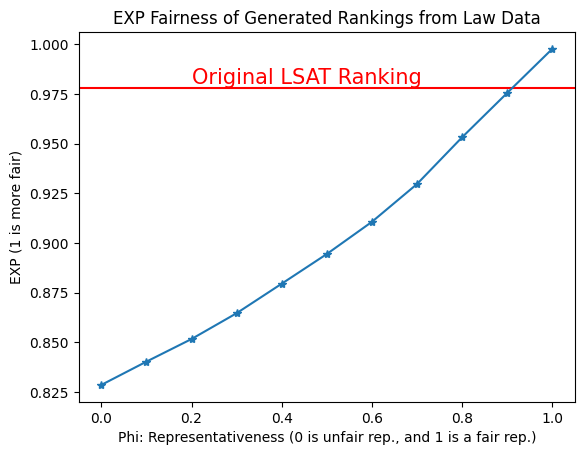

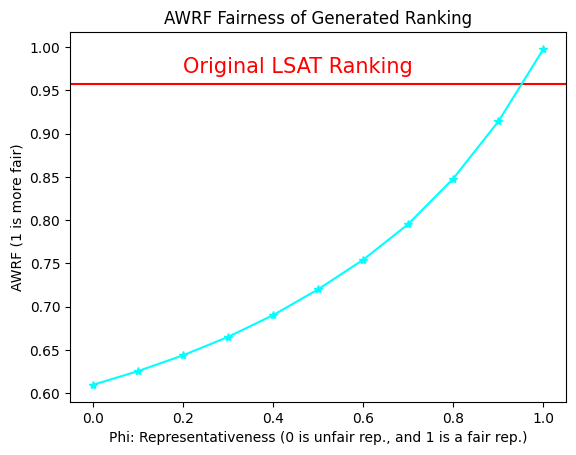

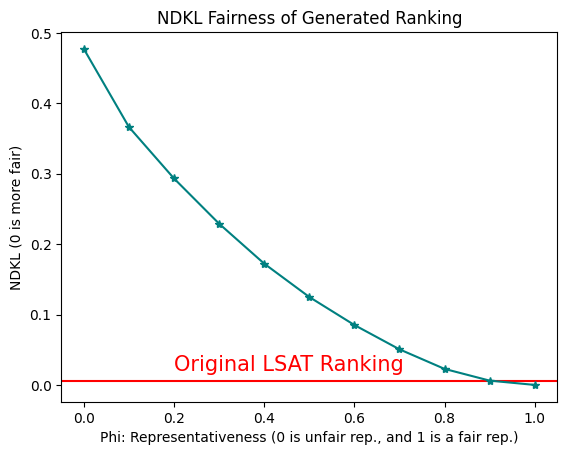

In [4]:
#plot EXP
xpoints = phis
ypoints = exps
plt.ylabel("EXP (1 is more fair)")
plt.xlabel("Phi: Representativeness (0 is unfair rep., and 1 is a fair rep.)")
plt.axhline(y=exp_original, color='r', linestyle='-')
plt.text(0.2, .98, 'Original LSAT Ranking',
        color='red', fontsize=15)
plt.title("EXP Fairness of Generated Rankings from Law Data")
plt.plot(xpoints, ypoints, marker='*')
plt.show()

# plot AWRF
xpoints = phis
ypoints = awrfs
plt.ylabel("AWRF (1 is more fair)")
plt.axhline(y=awrf_original, color='r', linestyle='-')
plt.text(0.2, .97, 'Original LSAT Ranking',
        color='red', fontsize=15)
plt.xlabel("Phi: Representativeness (0 is unfair rep., and 1 is a fair rep.)")
plt.title("AWRF Fairness of Generated Ranking")
plt.plot(xpoints, ypoints, marker='*', color='cyan')
plt.show()

# plot NDKL
xpoints = phis
ypoints = ndkls
plt.ylabel("NDKL (0 is more fair)")
plt.axhline(y=ndkl_original, color='r', linestyle='-')
plt.text(0.2, .02, 'Original LSAT Ranking',
        color='red', fontsize=15)
plt.xlabel("Phi: Representativeness (0 is unfair rep., and 1 is a fair rep.)")
plt.title("NDKL Fairness of Generated Ranking")
plt.plot(xpoints, ypoints, marker='*', color='teal')
plt.show()

We can see that the original LSAT ranking is not very unfair. It tends to be similiar in fairness to rankings produced by `phi = 0.9`. RankTune can augment the `Law` dataset by generating differnt ranking of different fairness levels over the same set of item. This could be useful in generating data for crowd-sourced user studies or tasks like rank aggregation.